# **CT5133 Deep Learning - Assignment 2:**
## Unsupervised/self-supervised learning and generating images in Keras
**Submitted By:** Kalyani Prashant Kawale

**Student ID:** 21237189


## **Section 1: Image Dataset**

> Details here


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Colab Notebooks/DeepLearning/Assignment2

/content/drive/MyDrive/Colab Notebooks/DeepLearning/Assignment2


In [ ]:
# Loading libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Conv2D, Conv2DTranspose, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.losses import mse
from keras import backend as K
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from keras.datasets import mnist
import glob
import imageio
import PIL
import time

from IPython import display

%matplotlib inline

In [ ]:
# Saving image file names in images list
path = './weather'
images = [os.path.join(path, img) for img in os.listdir(path)]

In [ ]:
# Shuffling the images and setting seed for reproducibility
np.random.seed(200)
np.random.shuffle(images)

In [ ]:
image_arr = []
for img in images:
  image_arr.append(cv2.imread(img))

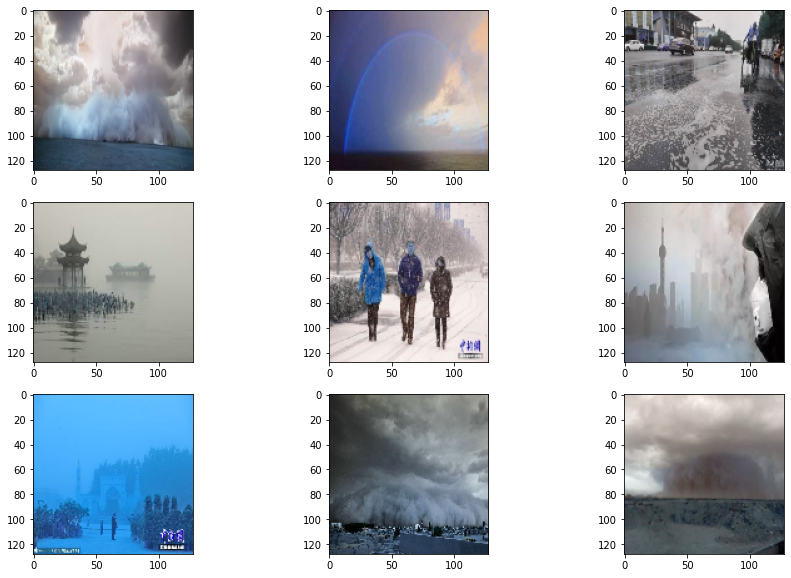

In [ ]:
fig = plt.figure(figsize=(15, 10))
columns = 3
rows = 3

for index, img in enumerate(image_arr[0:9]):
  image = cv2.resize(img, (32, 32))  
  fig.add_subplot(rows, columns, index+1)
  plt.imshow(image)
  
plt.show()

In [ ]:
dataset = []
for img in image_arr:
  try:
    dataset.append(cv2.resize(img, (128, 128)))
  except:
    pass

In [ ]:
dataset = np.array(dataset)/255 # Normalizing image pixels between 0 to 1

In [ ]:
dataset = tf.cast(dataset, tf.float32)

In [ ]:
dataset.shape

TensorShape([3172, 128, 128, 3])

## **Section 2: Building Auto-Encoder, Variational Auto-Encoder, and Generative Adversarial Network**

> **Initializing common settings**:

In [ ]:
# Setting input and latent space dimensions
image_dim = (128, 128, 3)
latent_dim = 100
EPOCHS = 20
BATCH_SIZE = 200

> **Defining a common method for performing & displaying reconstructed images**:

how are images reconstructed

In [ ]:
# Following code is based on plot_compare method taken from [7]
def reconstruct_results(generation_model, model, num_images=5, start=0):
  # sampling num_images number of images from the dataset
  sample_images = dataset[start:(start + num_images)]
  # Using the autoencoder/vae to reconstruct images using predict method
  reconstructed_imgs = generation_model.predict(sample_images)
  # Configuring figure to plot images
  img_len = len(sample_images)
  fig = plt.figure(figsize=(num_images + 10, 5))  
  # Configuring to plot the sampled dataset images
  for i in range(img_len):
    img = sample_images[i]
    sub = fig.add_subplot(2, img_len, i+1)
    sub.axis('off')
    sub.imshow(img)
  # Configuring to plot the reconstructed images below the original images
  for i in range(img_len):
    img = reconstructed_imgs[i]
    sub = fig.add_subplot(2, img_len, i+img_len+1)
    sub.axis('off')
    sub.imshow(img)
  plt.savefig(f'{model}_reconstruct_images.png')

> **Defining a common method to generate and display new samples**:

how are new samples generated

In [ ]:
# Following plotting logic taken from [8]
def generate_images(img_generator, model, latent_dim, num_images=9):
  # Generating new images using img_generator, 
  # which is decoder in case of autoencoder and vae
  # and generator in case of GAN
  new_images = img_generator.predict(np.random.normal(0, 1, size=(num_images, latent_dim)))     
  # Configuring figure plot to display images in 3x3 grid
  fig = plt.figure(figsize=(15, 10))
  columns = 3
  rows = 3
  for i in range(columns*rows):
    # Setting the position of image in the grid
    fig.add_subplot(rows, columns, i+1)
    # Adding generated image to plot 
    plt.imshow((255 * new_images[i]).astype(np.uint8))
  # Displaying the 3x3 grid with all generated images
  plt.savefig(f'{model}_images.png')
  plt.show()

### Auto-Encoder

> **Defining build method for autoencoder specifying the network architecture**:

In [ ]:
# Following code is a modified version of code taken from [6]
def build_autoencoder(image_dim, latent_dim):
    # The encoder
    # encoder = Sequential()
    # encoder.add(InputLayer(image_dim))
    # encoder.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
    # encoder.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
    # encoder.add(Flatten())
    # encoder.add(Dense(latent_dim))
    encoder = Sequential()
    encoder.add(InputLayer(image_dim))
    encoder.add(Conv2D(filters=16, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    encoder.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    encoder.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    encoder.add(Flatten())
    encoder.add(Dense(latent_dim))

    # The decoder
    # decoder = Sequential()
    # decoder.add(InputLayer((latent_dim,)))
    # decoder.add(Dense(np.prod(image_dim))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    # decoder.add(Reshape(image_dim))
    # decoder.add(Conv2DTranspose(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
    # decoder.add(Conv2DTranspose(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
    # decoder.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), padding='same', 
    #                             activation='sigmoid'))

    decoder = Sequential()
    decoder.add(InputLayer((latent_dim,)))
    decoder.add(Dense(np.prod(image_dim))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(image_dim))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    decoder.add(Conv2DTranspose(filters=16, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    decoder.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), padding='same', activation='sigmoid'))
    
    # Configuring the Auto-Encoder
    original_inputs = Input(image_dim, name="encoder_input")
    encode = encoder(original_inputs)
    reconstruction = decoder(encode)
    autoencoder = Model(original_inputs, reconstruction)

    return autoencoder, encoder, decoder


> **Building and compiling the autoencoder**:

In [ ]:
autoencoder, encoder, decoder = build_autoencoder(image_dim, latent_dim)
optimizer = keras.optimizers.Adam(1e-3)
# Compiling the auto-encoder
autoencoder.compile(optimizer=optimizer, loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 100)               104881284 
                                                                 
 sequential_9 (Sequential)   (None, 128, 128, 3)       4989667   
                                                                 
Total params: 109,870,951
Trainable params: 109,870,951
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoder.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128, 128, 16)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 flatten_4 (Flatten)         (None, 1048576)          

In [ ]:
decoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 49152)             4964352   
                                                                 
 reshape_5 (Reshape)         (None, 128, 128, 3)       0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 128, 128, 64)     1792      
 Transpose)                                                      
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 128, 128, 32)     18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 128, 128, 16)     4624      
 Transpose)                                                      
                                                      

> **Training the autoencoder with --- dataset**:

In [ ]:
# Training model and saving the returned History object in history
history = autoencoder.fit(x=dataset, y=dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20


ResourceExhaustedError: ignored

> **Plotting the learning curve for autoencoder**:



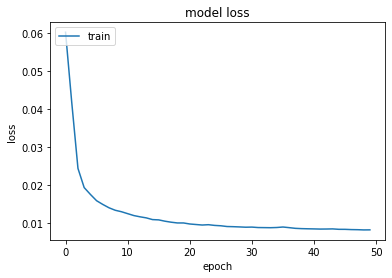

In [ ]:
# Plotting the loss fetched from the History object returned by fit method
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

> **Checking the reconstruction of images performed by autoencoder**:

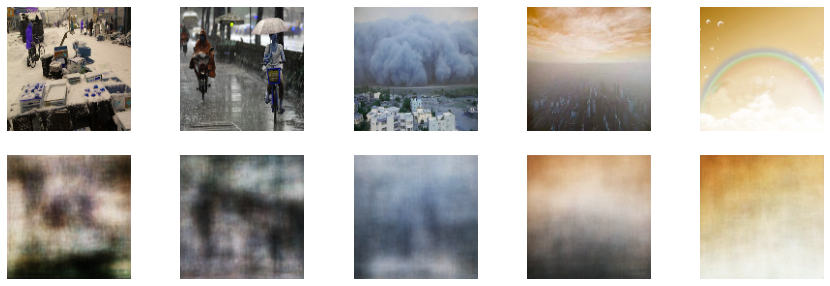

In [ ]:
# reconstruct_results(autoencoder, num_images=5, start=110)
# reconstruct_results(autoencoder, num_images=5, start=782)
# reconstruct_results(autoencoder, num_images=5, start=1987)

reconstruct_results(autoencoder, 'autoencoder', num_images=5, start=1996)

> **Generating new samples using autoencoder**:

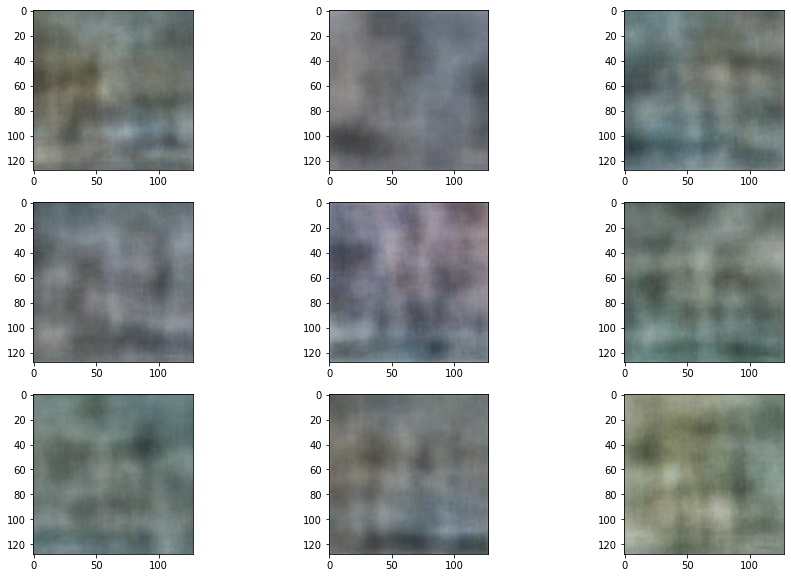

In [ ]:
# Generating 9 samples using autoencoder's decoder
generate_images(decoder, 'autoencoder', latent_dim)

### Variational Auto-Encoder:

Explain what that is

> **Defining Sampling layer to be used by variational autoencoder**:

In [ ]:
# Following code is taken from [5]
# Custom sampling layer used to get the latent space
class Sampling(keras.layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
  def call(self, inputs):
    # override the inherited .call(self, inputs) method
    z_mean, z_log_var = inputs
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean)) # N(0, 1)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon # N(mu, sigma)

> **Defining build method for variational autoencoder specifying the network architecture**:

In [ ]:
# Following code is a modified version of code taken from [5]
def build_vae(image_dim, latent_dim):
  # Encoder
  # original_inputs = Input(shape=(image_dim), name="encoder_input")
  # x = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(original_inputs)
  # x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
  # x = Flatten()(x)
  # z_mean = Dense(latent_dim, name="z_mean")(x)
  # z_log_var = Dense(latent_dim, name="z_log_var")(x)
  # z = Sampling()((z_mean, z_log_var))
  # vae_encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

  original_inputs = Input(shape=(image_dim), name="encoder_input")
  x = Conv2D(filters=16, kernel_size=(3,3), padding='same')(original_inputs)
  x = LeakyReLU()(x)
  x = Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  x = Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  x = Flatten()(x)
  z_mean = Dense(latent_dim, name="z_mean")(x)
  z_log_var = Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()((z_mean, z_log_var))
  vae_encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

  # Decoder
  latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
  x = Dense(np.prod(image_dim))(latent_inputs)
  x = Reshape(image_dim)(x)
  x = Conv2DTranspose(filters=64, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  x = Conv2DTranspose(filters=32, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  x = Conv2DTranspose(filters=16, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  outputs = Conv2DTranspose(filters=3, kernel_size=(3, 3), padding='same', activation='sigmoid')(x)  
  vae_decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")    

  # Define VAE model.
  outputs = vae_decoder(z)
  vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

  # Loss approach from
  # https://gist.github.com/tik0/6aa42cabb9cf9e21567c3deb309107b7  
  reconstruction_loss = mse(original_inputs, outputs) # xhat should match x
  reconstruction_loss = np.prod(image_dim) * K.mean(reconstruction_loss)
  kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

  # Setting up reconstruction and Kullback-Leibler regularisation losses on the model, 
  # and adding them as metrics for the model.
  # The Model's loss is the sum of the two losses.
  vae.add_loss(kl_loss)
  vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
  vae.add_loss(reconstruction_loss)
  vae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

  return vae, vae_encoder, vae_decoder

> **Building and compiling the variational autoencoder**:

optimizer details

In [ ]:
vae, vae_encoder, vae_decoder = build_vae(image_dim, latent_dim)
vae_optimizer = keras.optimizers.Adam(1e-3)
vae.compile(optimizer=vae_optimizer)

In [ ]:
vae_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 16  448         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 128, 128, 16  0           ['conv2d_15[0][0]']              
                                )                                                           

In [ ]:
vae_decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 100)]             0         
                                                                 
 dense_11 (Dense)            (None, 49152)             4964352   
                                                                 
 reshape_7 (Reshape)         (None, 128, 128, 3)       0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 128, 128, 64)     1792      
 Transpose)                                                      
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 128, 128, 32)     18464     
 Transpose)                                                

> **Training the variational autoencoder with ---- dataset**:

In [ ]:
vae_history = vae.fit(x=dataset, y=dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50


ResourceExhaustedError: ignored

> **Plotting the learning curve for variational autoencoder**:

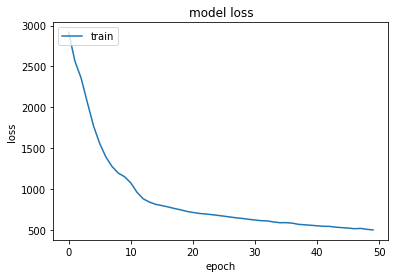

In [ ]:
plt.plot(vae_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

> **Checking the reconstruction of images performed by variational autoencoder**:

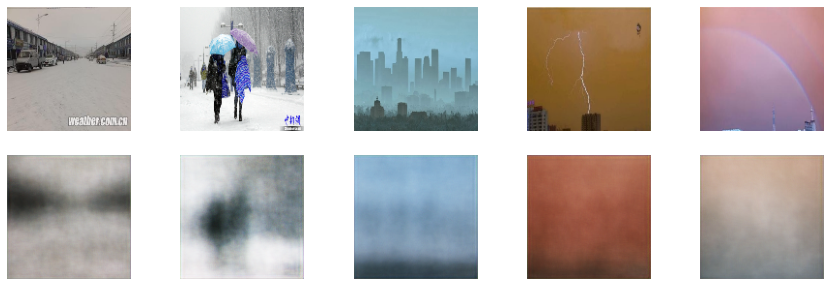

In [ ]:
reconstruct_results(vae, num_images=5, start=1996)
# reconstruct_results(vae, 'vae', num_images=5, start=1969)

> **Generating new samples using variational autoencoder**:

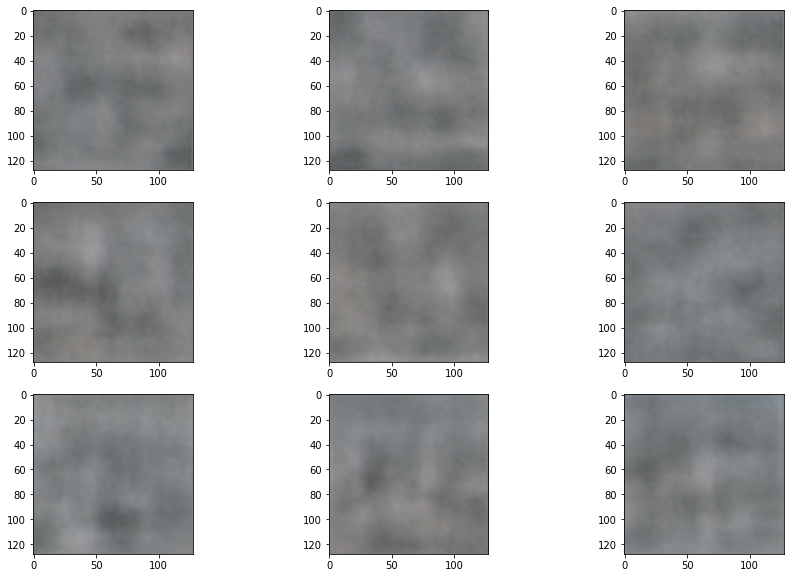

In [ ]:
# Generating 9 samples using variational autoencoder's decoder
generate_images(vae_decoder, 'vae', latent_dim)

### Generative Adversarial Network:

explain what that is

> **Designing the generator architecture**:

In [ ]:
def make_generator_model(image_dim, latent_dim):
    # G = Sequential()
    # G.add(InputLayer((latent_dim,)))
    # G.add(Dense(np.prod(image_dim), use_bias=False)) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    # G.add(Reshape(image_dim))
    # G.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    # G.add(Conv2DTranspose(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
    # G.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), padding='same', activation='sigmoid'))

    G = Sequential()
    G.add(InputLayer((latent_dim,)))
    G.add(Dense(np.prod(image_dim), use_bias=False)) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    G.add(Reshape(image_dim))
    G.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same'))
    G.add(LeakyReLU())
    G.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), padding='same'))
    G.add(LeakyReLU())
    G.add(Conv2DTranspose(filters=16, kernel_size=(3, 3), padding='same'))
    G.add(LeakyReLU())
    G.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), padding='same', activation='sigmoid'))
    return G

> **Initializing the generator model and checking random image generation**:

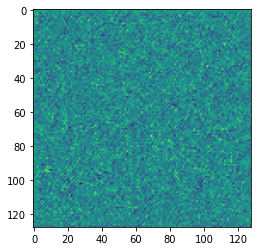

In [ ]:
generator = make_generator_model(image_dim, latent_dim)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

> **Designing discriminator architecture**:

In [ ]:
def make_discriminator_model(image_dim, latent_dim):
    
    # D = Sequential()
    # D.add(InputLayer(image_dim))
    # D.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
    # D.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
    # D.add(Flatten())
    # D.add(Dense(1))

    
    D = Sequential()
    D.add(InputLayer(image_dim))
    D.add(Conv2D(filters=16, kernel_size=(3,3), padding='same'))
    D.add(LeakyReLU())
    D.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
    D.add(LeakyReLU())
    D.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
    D.add(LeakyReLU())
    D.add(Flatten())
    D.add(Dense(1))

    return D

> **Using the discriminator model to identify if the image generated by the generator is real or fake**:


In [ ]:
discriminator = make_discriminator_model(image_dim, latent_dim)
decision = discriminator(generated_image) # output 0 for fake and output 1 for real
print (decision)

tf.Tensor([[0.00289676]], shape=(1, 1), dtype=float32)


> **Defining the losses for both generator and discriminator**:

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


> **Setting optimizers for generator and discriminator**:

In [ ]:
generator_optimizer = keras.optimizers.Adam(1e-3)
discriminator_optimizer = keras.optimizers.Adam(1e-3)

In [ ]:
# Saving checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

> **Defining the GAN training methods**:

In [ ]:
num_examples_to_generate = 9

# Random sample to check training progress
seed = tf.random.normal([num_examples_to_generate, latent_dim])

In [ ]:
# Using `tf.function` for compiling the train_step method.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # `training` set to False to run all layers in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(15, 10))

  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

> **Dataset preparation for training GAN with ---- dataset**:

In [ ]:
BUFFER_SIZE = len(dataset)

In [ ]:
# Batching and shuffling the data using the common batch size and shuffling with entire data-set
gan_train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

> **Training the deep convolutional GAN with --- dataset**:

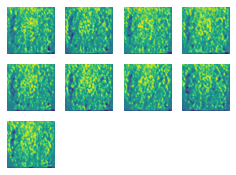

In [ ]:
train(gan_train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

> **Method to display images generated by GAN during training**:

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
# Displaying generated images at the last epoch
display_image(EPOCHS)

> **Generating new samples using the trained generator of deep convolutional GAN**:


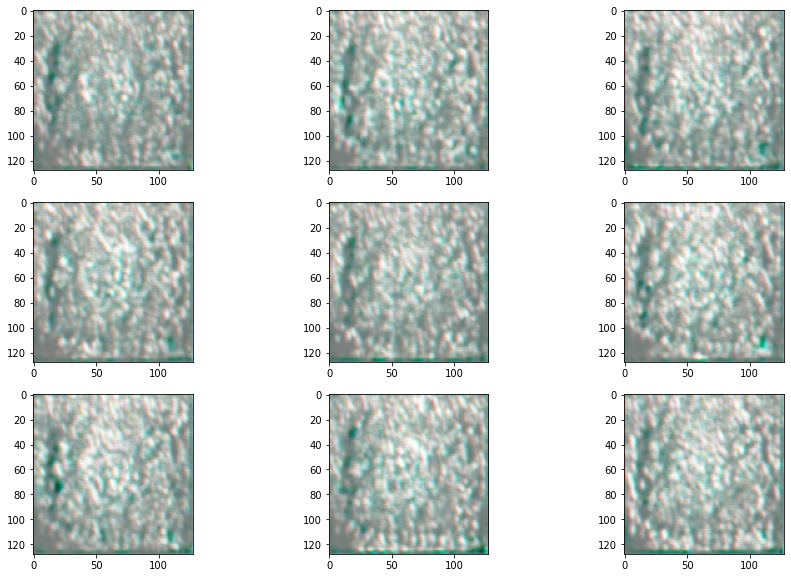

In [ ]:
# Generating 9 samples using GAN's generator
generate_images(generator, 'gan', latent_dim)

## **Section 3: Results**

END

## References & Acknowledgements:

Following resources were referred to perform the given tasks,

[1] https://www.kaggle.com/jehanbhathena/weather-dataset

[2] Dr. M. Madden. (2021). Load and View CIFAR-10 Data.

[3] Dr. I. Ullah. (2022). ImageProcessing_CV.

[4] Dr. J. McDermott. (2022). Week 7 Lecture Material. Source Code: keras_mnist.py

[5] Dr. J. McDermott. (2022). Week 8 Lecture Material. Source Code: vae.py

[6] Ali Abdelaal. Autoencoders for Image Reconstruction in Python and Keras. Available at: https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/

[7] Dhanush Kamath. (2020). Generating New Faces With Variational Autoencoders. Available at: https://www.topbots.com/generating-new-faces-with-variational-autoencoders/

[8] How to display multiple images in one figure correctly? [duplicate]. (2021). Available at: https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645

[9] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). (2021). Available at: https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa

[10] Muhammad Ardi. (2020). Using Variational Autoencoder (VAE) to Generate New Images. Available at: https://becominghuman.ai/using-variational-autoencoder-vae-to-generate-new-images-14328877e88d

[11] Deep Convolutional Generative Adversarial Network. Available at: https://www.tensorflow.org/tutorials/generative/dcgan